<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:08:14] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


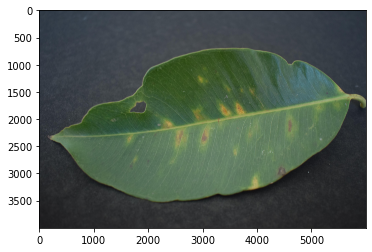

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

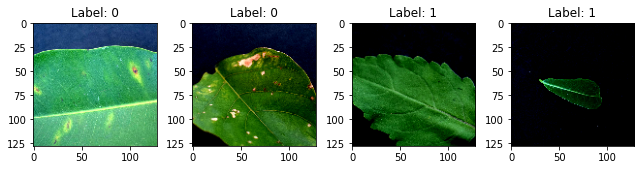

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:08:20] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:08:22] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.242403162003821 samples/sec                   batch loss = 0.5254107713699341 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.2592886825654601 samples/sec                   batch loss = 0.5313384532928467 | accuracy = 0.675


Epoch[1] Batch[15] Speed: 1.2589431122170838 samples/sec                   batch loss = 2.518305540084839 | accuracy = 0.55


Epoch[1] Batch[20] Speed: 1.2543080819702992 samples/sec                   batch loss = 0.6464106440544128 | accuracy = 0.5875


Epoch[1] Batch[25] Speed: 1.263007903013805 samples/sec                   batch loss = 0.5090210437774658 | accuracy = 0.58


Epoch[1] Batch[30] Speed: 1.2578276590619442 samples/sec                   batch loss = 0.7504435181617737 | accuracy = 0.5916666666666667


Epoch[1] Batch[35] Speed: 1.2440932655281447 samples/sec                   batch loss = 0.7732331156730652 | accuracy = 0.5785714285714286


Epoch[1] Batch[40] Speed: 1.2507882839393754 samples/sec                   batch loss = 0.4363221228122711 | accuracy = 0.6


Epoch[1] Batch[45] Speed: 1.2597645891693778 samples/sec                   batch loss = 0.5422614812850952 | accuracy = 0.5944444444444444


Epoch[1] Batch[50] Speed: 1.2545538214382443 samples/sec                   batch loss = 0.3070065677165985 | accuracy = 0.61


Epoch[1] Batch[55] Speed: 1.2495109490366667 samples/sec                   batch loss = 0.6860262751579285 | accuracy = 0.6181818181818182


Epoch[1] Batch[60] Speed: 1.2558093439934657 samples/sec                   batch loss = 0.45976006984710693 | accuracy = 0.6125


Epoch[1] Batch[65] Speed: 1.25246810006238 samples/sec                   batch loss = 0.771180272102356 | accuracy = 0.6153846153846154


Epoch[1] Batch[70] Speed: 1.2565775110049293 samples/sec                   batch loss = 0.4093034267425537 | accuracy = 0.6178571428571429


Epoch[1] Batch[75] Speed: 1.2517501483062718 samples/sec                   batch loss = 0.49273890256881714 | accuracy = 0.63


Epoch[1] Batch[80] Speed: 1.260088274893239 samples/sec                   batch loss = 0.3220384120941162 | accuracy = 0.63125


Epoch[1] Batch[85] Speed: 1.2642721237425922 samples/sec                   batch loss = 1.029571771621704 | accuracy = 0.6352941176470588


Epoch[1] Batch[90] Speed: 1.2576865986098833 samples/sec                   batch loss = 0.5233908295631409 | accuracy = 0.6416666666666667


Epoch[1] Batch[95] Speed: 1.2582749053399758 samples/sec                   batch loss = 0.7533339262008667 | accuracy = 0.6368421052631579


Epoch[1] Batch[100] Speed: 1.2672618296768248 samples/sec                   batch loss = 0.5994412302970886 | accuracy = 0.6375


Epoch[1] Batch[105] Speed: 1.2572432563147802 samples/sec                   batch loss = 0.6342633366584778 | accuracy = 0.6428571428571429


Epoch[1] Batch[110] Speed: 1.2667473402008271 samples/sec                   batch loss = 0.3692997694015503 | accuracy = 0.6522727272727272


Epoch[1] Batch[115] Speed: 1.2682645470383869 samples/sec                   batch loss = 0.40438082814216614 | accuracy = 0.6543478260869565


Epoch[1] Batch[120] Speed: 1.2467863542376367 samples/sec                   batch loss = 0.45668432116508484 | accuracy = 0.6541666666666667


Epoch[1] Batch[125] Speed: 1.2568367570837837 samples/sec                   batch loss = 0.5635151267051697 | accuracy = 0.654


Epoch[1] Batch[130] Speed: 1.2577412840670739 samples/sec                   batch loss = 0.44461309909820557 | accuracy = 0.6596153846153846


Epoch[1] Batch[135] Speed: 1.2569164162468196 samples/sec                   batch loss = 0.5278782844543457 | accuracy = 0.6592592592592592


Epoch[1] Batch[140] Speed: 1.255410722866918 samples/sec                   batch loss = 0.6436985731124878 | accuracy = 0.6571428571428571


Epoch[1] Batch[145] Speed: 1.2585477864299583 samples/sec                   batch loss = 0.396484375 | accuracy = 0.6603448275862069


Epoch[1] Batch[150] Speed: 1.2497863724905425 samples/sec                   batch loss = 0.7846421599388123 | accuracy = 0.66


Epoch[1] Batch[155] Speed: 1.2581940359655726 samples/sec                   batch loss = 0.6263876557350159 | accuracy = 0.6596774193548387


Epoch[1] Batch[160] Speed: 1.258983357575411 samples/sec                   batch loss = 0.7802422046661377 | accuracy = 0.65625


Epoch[1] Batch[165] Speed: 1.252020393259341 samples/sec                   batch loss = 0.401861310005188 | accuracy = 0.6606060606060606


Epoch[1] Batch[170] Speed: 1.2564198882184874 samples/sec                   batch loss = 0.5931646823883057 | accuracy = 0.6558823529411765


Epoch[1] Batch[175] Speed: 1.2567861043810458 samples/sec                   batch loss = 0.4995475709438324 | accuracy = 0.6557142857142857


Epoch[1] Batch[180] Speed: 1.2555221459072017 samples/sec                   batch loss = 0.4705653190612793 | accuracy = 0.6513888888888889


Epoch[1] Batch[185] Speed: 1.2571160793169565 samples/sec                   batch loss = 0.2572741210460663 | accuracy = 0.65


Epoch[1] Batch[190] Speed: 1.262509401724838 samples/sec                   batch loss = 0.5454220771789551 | accuracy = 0.65


Epoch[1] Batch[195] Speed: 1.2645818307022827 samples/sec                   batch loss = 0.8047155737876892 | accuracy = 0.6538461538461539


Epoch[1] Batch[200] Speed: 1.2558521154177384 samples/sec                   batch loss = 1.8873533010482788 | accuracy = 0.65


Epoch[1] Batch[205] Speed: 1.2624005346604132 samples/sec                   batch loss = 1.054103136062622 | accuracy = 0.6475609756097561


Epoch[1] Batch[210] Speed: 1.2573555702862607 samples/sec                   batch loss = 0.6285851001739502 | accuracy = 0.6428571428571429


Epoch[1] Batch[215] Speed: 1.2631500646173086 samples/sec                   batch loss = 0.4958609640598297 | accuracy = 0.6383720930232558


Epoch[1] Batch[220] Speed: 1.2629221460713216 samples/sec                   batch loss = 0.4012446105480194 | accuracy = 0.6375


Epoch[1] Batch[225] Speed: 1.260333444313165 samples/sec                   batch loss = 0.2675815224647522 | accuracy = 0.6388888888888888


Epoch[1] Batch[230] Speed: 1.2600359402655872 samples/sec                   batch loss = 0.7750682234764099 | accuracy = 0.6391304347826087


Epoch[1] Batch[235] Speed: 1.2587472126464614 samples/sec                   batch loss = 1.5954338312149048 | accuracy = 0.6436170212765957


Epoch[1] Batch[240] Speed: 1.2647794553670602 samples/sec                   batch loss = 0.5823752880096436 | accuracy = 0.6447916666666667


Epoch[1] Batch[245] Speed: 1.2633904332973531 samples/sec                   batch loss = 0.4816478490829468 | accuracy = 0.6489795918367347


Epoch[1] Batch[250] Speed: 1.262287982438796 samples/sec                   batch loss = 0.5645057559013367 | accuracy = 0.648


Epoch[1] Batch[255] Speed: 1.2637562507184192 samples/sec                   batch loss = 0.8184406757354736 | accuracy = 0.6450980392156863


Epoch[1] Batch[260] Speed: 1.274347726484155 samples/sec                   batch loss = 1.1188669204711914 | accuracy = 0.6451923076923077


Epoch[1] Batch[265] Speed: 1.260643971359848 samples/sec                   batch loss = 0.9394698143005371 | accuracy = 0.6433962264150943


Epoch[1] Batch[270] Speed: 1.2605874230204028 samples/sec                   batch loss = 0.4805501699447632 | accuracy = 0.6444444444444445


Epoch[1] Batch[275] Speed: 1.2534161631749474 samples/sec                   batch loss = 0.8296117782592773 | accuracy = 0.6427272727272727


Epoch[1] Batch[280] Speed: 1.2637487304863235 samples/sec                   batch loss = 0.586402416229248 | accuracy = 0.64375


Epoch[1] Batch[285] Speed: 1.261082037603318 samples/sec                   batch loss = 1.0774041414260864 | accuracy = 0.6429824561403509


Epoch[1] Batch[290] Speed: 1.2613473184177946 samples/sec                   batch loss = 0.4976590573787689 | accuracy = 0.6456896551724138


Epoch[1] Batch[295] Speed: 1.2516840293903593 samples/sec                   batch loss = 0.4109458923339844 | accuracy = 0.6449152542372881


Epoch[1] Batch[300] Speed: 1.2508168190162863 samples/sec                   batch loss = 0.8905870318412781 | accuracy = 0.6441666666666667


Epoch[1] Batch[305] Speed: 1.2493407665806207 samples/sec                   batch loss = 1.2665371894836426 | accuracy = 0.6434426229508197


Epoch[1] Batch[310] Speed: 1.248770356268993 samples/sec                   batch loss = 0.6140277981758118 | accuracy = 0.6459677419354839


Epoch[1] Batch[315] Speed: 1.2492684833061696 samples/sec                   batch loss = 0.4360399544239044 | accuracy = 0.6468253968253969


Epoch[1] Batch[320] Speed: 1.2550305678332407 samples/sec                   batch loss = 0.5163220167160034 | accuracy = 0.64765625


Epoch[1] Batch[325] Speed: 1.2501564631482063 samples/sec                   batch loss = 0.4485567510128021 | accuracy = 0.65


Epoch[1] Batch[330] Speed: 1.2450370029554128 samples/sec                   batch loss = 1.0430543422698975 | accuracy = 0.6530303030303031


Epoch[1] Batch[335] Speed: 1.244866281920852 samples/sec                   batch loss = 0.5534246563911438 | accuracy = 0.655223880597015


Epoch[1] Batch[340] Speed: 1.249593312032102 samples/sec                   batch loss = 0.4794895052909851 | accuracy = 0.6544117647058824


Epoch[1] Batch[345] Speed: 1.2531731156782584 samples/sec                   batch loss = 0.6865633726119995 | accuracy = 0.6543478260869565


Epoch[1] Batch[350] Speed: 1.2519914295249166 samples/sec                   batch loss = 0.37672215700149536 | accuracy = 0.6564285714285715


Epoch[1] Batch[355] Speed: 1.264768585835498 samples/sec                   batch loss = 0.7958469986915588 | accuracy = 0.6570422535211268


Epoch[1] Batch[360] Speed: 1.2622168521874093 samples/sec                   batch loss = 0.4778924286365509 | accuracy = 0.6569444444444444


Epoch[1] Batch[365] Speed: 1.2599924102525126 samples/sec                   batch loss = 0.4013494551181793 | accuracy = 0.6554794520547945


Epoch[1] Batch[370] Speed: 1.2627245311244382 samples/sec                   batch loss = 0.4991896450519562 | accuracy = 0.6567567567567567


Epoch[1] Batch[375] Speed: 1.2610271560434307 samples/sec                   batch loss = 0.2679271697998047 | accuracy = 0.6586666666666666


Epoch[1] Batch[380] Speed: 1.2534902383752549 samples/sec                   batch loss = 0.28845012187957764 | accuracy = 0.6598684210526315


Epoch[1] Batch[385] Speed: 1.2562554380626196 samples/sec                   batch loss = 0.5656020045280457 | accuracy = 0.6597402597402597


Epoch[1] Batch[390] Speed: 1.2544200596957789 samples/sec                   batch loss = 0.8109449744224548 | accuracy = 0.6583333333333333


Epoch[1] Batch[395] Speed: 1.2608587497149821 samples/sec                   batch loss = 0.6697965860366821 | accuracy = 0.6613924050632911


Epoch[1] Batch[400] Speed: 1.2507388635204046 samples/sec                   batch loss = 0.18185648322105408 | accuracy = 0.663125


Epoch[1] Batch[405] Speed: 1.2495990825020469 samples/sec                   batch loss = 0.26463809609413147 | accuracy = 0.6635802469135802


Epoch[1] Batch[410] Speed: 1.2537483057017051 samples/sec                   batch loss = 0.30129921436309814 | accuracy = 0.6658536585365854


Epoch[1] Batch[415] Speed: 1.2559479151772581 samples/sec                   batch loss = 0.2994902431964874 | accuracy = 0.6650602409638554


Epoch[1] Batch[420] Speed: 1.2596937430134711 samples/sec                   batch loss = 0.3343069553375244 | accuracy = 0.6666666666666666


Epoch[1] Batch[425] Speed: 1.25676162684301 samples/sec                   batch loss = 0.5547599792480469 | accuracy = 0.6676470588235294


Epoch[1] Batch[430] Speed: 1.2506578411330902 samples/sec                   batch loss = 0.7500414848327637 | accuracy = 0.6680232558139535


Epoch[1] Batch[435] Speed: 1.2645194959382817 samples/sec                   batch loss = 0.31189143657684326 | accuracy = 0.6701149425287356


Epoch[1] Batch[440] Speed: 1.257551979507646 samples/sec                   batch loss = 0.4935483932495117 | accuracy = 0.6704545454545454


Epoch[1] Batch[445] Speed: 1.2555515551179437 samples/sec                   batch loss = 0.5841600894927979 | accuracy = 0.6719101123595506


Epoch[1] Batch[450] Speed: 1.2533736511484017 samples/sec                   batch loss = 0.1917250156402588 | accuracy = 0.6722222222222223


Epoch[1] Batch[455] Speed: 1.2559971839433866 samples/sec                   batch loss = 0.7936659455299377 | accuracy = 0.6736263736263737


Epoch[1] Batch[460] Speed: 1.2572695427695455 samples/sec                   batch loss = 0.5696749091148376 | accuracy = 0.6733695652173913


Epoch[1] Batch[465] Speed: 1.2566305940856806 samples/sec                   batch loss = 0.48061856627464294 | accuracy = 0.6752688172043011


Epoch[1] Batch[470] Speed: 1.2572468364841036 samples/sec                   batch loss = 0.7016563415527344 | accuracy = 0.6734042553191489


Epoch[1] Batch[475] Speed: 1.2655558703626426 samples/sec                   batch loss = 0.946806788444519 | accuracy = 0.6742105263157895


Epoch[1] Batch[480] Speed: 1.2648467743467617 samples/sec                   batch loss = 0.32095569372177124 | accuracy = 0.6760416666666667


Epoch[1] Batch[485] Speed: 1.251320033527218 samples/sec                   batch loss = 0.48375722765922546 | accuracy = 0.6762886597938145


Epoch[1] Batch[490] Speed: 1.2624200077563676 samples/sec                   batch loss = 1.1747194528579712 | accuracy = 0.6739795918367347


Epoch[1] Batch[495] Speed: 1.2656583122625602 samples/sec                   batch loss = 0.8233538866043091 | accuracy = 0.6732323232323232


Epoch[1] Batch[500] Speed: 1.2588455326302936 samples/sec                   batch loss = 0.5387005805969238 | accuracy = 0.6745


Epoch[1] Batch[505] Speed: 1.2547228935629962 samples/sec                   batch loss = 0.44536590576171875 | accuracy = 0.6742574257425743


Epoch[1] Batch[510] Speed: 1.2520111434049592 samples/sec                   batch loss = 0.4677067697048187 | accuracy = 0.6735294117647059


Epoch[1] Batch[515] Speed: 1.2564266628323568 samples/sec                   batch loss = 0.29824668169021606 | accuracy = 0.6733009708737864


Epoch[1] Batch[520] Speed: 1.2530560259029793 samples/sec                   batch loss = 0.468903124332428 | accuracy = 0.6721153846153847


Epoch[1] Batch[525] Speed: 1.2092881243048863 samples/sec                   batch loss = 1.1754887104034424 | accuracy = 0.6723809523809524


Epoch[1] Batch[530] Speed: 1.2563869571084585 samples/sec                   batch loss = 0.4148216247558594 | accuracy = 0.6735849056603773


Epoch[1] Batch[535] Speed: 1.2521180389473328 samples/sec                   batch loss = 0.23990373313426971 | accuracy = 0.6733644859813084


Epoch[1] Batch[540] Speed: 1.2506865567276373 samples/sec                   batch loss = 0.35433638095855713 | accuracy = 0.674537037037037


Epoch[1] Batch[545] Speed: 1.2549626938212453 samples/sec                   batch loss = 0.5305836200714111 | accuracy = 0.6747706422018349


Epoch[1] Batch[550] Speed: 1.257396373870535 samples/sec                   batch loss = 0.5826438069343567 | accuracy = 0.675


Epoch[1] Batch[555] Speed: 1.2502641602684326 samples/sec                   batch loss = 0.39851874113082886 | accuracy = 0.6747747747747748


Epoch[1] Batch[560] Speed: 1.2523964828543255 samples/sec                   batch loss = 0.4877795875072479 | accuracy = 0.6745535714285714


Epoch[1] Batch[565] Speed: 1.2520476764542097 samples/sec                   batch loss = 0.45075154304504395 | accuracy = 0.6738938053097345


Epoch[1] Batch[570] Speed: 1.2709012730665574 samples/sec                   batch loss = 0.2986666262149811 | accuracy = 0.6732456140350878


Epoch[1] Batch[575] Speed: 1.267719642993829 samples/sec                   batch loss = 0.6678066849708557 | accuracy = 0.6734782608695652


Epoch[1] Batch[580] Speed: 1.2660320363784268 samples/sec                   batch loss = 0.4707145690917969 | accuracy = 0.6732758620689655


Epoch[1] Batch[585] Speed: 1.2653915969636724 samples/sec                   batch loss = 0.49716469645500183 | accuracy = 0.6747863247863248


Epoch[1] Batch[590] Speed: 1.259692986355216 samples/sec                   batch loss = 0.5700641870498657 | accuracy = 0.6745762711864407


Epoch[1] Batch[595] Speed: 1.262315809938933 samples/sec                   batch loss = 0.3922238349914551 | accuracy = 0.6743697478991597


Epoch[1] Batch[600] Speed: 1.2620390141583955 samples/sec                   batch loss = 0.24444177746772766 | accuracy = 0.67625


Epoch[1] Batch[605] Speed: 1.2652250762466082 samples/sec                   batch loss = 0.540589451789856 | accuracy = 0.6756198347107438


Epoch[1] Batch[610] Speed: 1.2644424914434362 samples/sec                   batch loss = 0.6123574376106262 | accuracy = 0.6745901639344263


Epoch[1] Batch[615] Speed: 1.2630778862655807 samples/sec                   batch loss = 0.9108712673187256 | accuracy = 0.6760162601626016


Epoch[1] Batch[620] Speed: 1.2688836183917007 samples/sec                   batch loss = 0.5585548877716064 | accuracy = 0.6766129032258065


Epoch[1] Batch[625] Speed: 1.2561821643597024 samples/sec                   batch loss = 0.2763324975967407 | accuracy = 0.678


Epoch[1] Batch[630] Speed: 1.2701478075072135 samples/sec                   batch loss = 0.7558525800704956 | accuracy = 0.6785714285714286


Epoch[1] Batch[635] Speed: 1.2697002503117072 samples/sec                   batch loss = 0.5389543771743774 | accuracy = 0.6787401574803149


Epoch[1] Batch[640] Speed: 1.265358766488313 samples/sec                   batch loss = 0.4542213976383209 | accuracy = 0.6796875


Epoch[1] Batch[645] Speed: 1.2623981599337124 samples/sec                   batch loss = 0.39898043870925903 | accuracy = 0.6810077519379845


Epoch[1] Batch[650] Speed: 1.2584553655024298 samples/sec                   batch loss = 0.2589662969112396 | accuracy = 0.681923076923077


Epoch[1] Batch[655] Speed: 1.2591976649190335 samples/sec                   batch loss = 0.37478259205818176 | accuracy = 0.6809160305343511


Epoch[1] Batch[660] Speed: 1.2538123003553632 samples/sec                   batch loss = 0.33566367626190186 | accuracy = 0.6814393939393939


Epoch[1] Batch[665] Speed: 1.2597197536936824 samples/sec                   batch loss = 0.39267027378082275 | accuracy = 0.6819548872180451


Epoch[1] Batch[670] Speed: 1.2567864809660014 samples/sec                   batch loss = 0.1858161836862564 | accuracy = 0.6828358208955224


Epoch[1] Batch[675] Speed: 1.2559929526953342 samples/sec                   batch loss = 0.5685433745384216 | accuracy = 0.6822222222222222


Epoch[1] Batch[680] Speed: 1.2618915026461999 samples/sec                   batch loss = 0.38463616371154785 | accuracy = 0.6819852941176471


Epoch[1] Batch[685] Speed: 1.265209333002625 samples/sec                   batch loss = 0.6589222550392151 | accuracy = 0.6821167883211678


Epoch[1] Batch[690] Speed: 1.2607254401980705 samples/sec                   batch loss = 0.22363154590129852 | accuracy = 0.683695652173913


Epoch[1] Batch[695] Speed: 1.2590364551537168 samples/sec                   batch loss = 0.5741524696350098 | accuracy = 0.6838129496402877


Epoch[1] Batch[700] Speed: 1.2578078558861794 samples/sec                   batch loss = 0.47091975808143616 | accuracy = 0.6842857142857143


Epoch[1] Batch[705] Speed: 1.2632737094191628 samples/sec                   batch loss = 1.169767141342163 | accuracy = 0.6847517730496454


Epoch[1] Batch[710] Speed: 1.2598859636527917 samples/sec                   batch loss = 0.28700029850006104 | accuracy = 0.6855633802816902


Epoch[1] Batch[715] Speed: 1.2491979756358527 samples/sec                   batch loss = 0.9795977473258972 | accuracy = 0.686013986013986


Epoch[1] Batch[720] Speed: 1.2537053027158283 samples/sec                   batch loss = 0.532728910446167 | accuracy = 0.6864583333333333


Epoch[1] Batch[725] Speed: 1.2485914548533987 samples/sec                   batch loss = 0.9366402626037598 | accuracy = 0.6858620689655173


Epoch[1] Batch[730] Speed: 1.2490354104462 samples/sec                   batch loss = 0.6139100193977356 | accuracy = 0.6856164383561644


Epoch[1] Batch[735] Speed: 1.2497823691849963 samples/sec                   batch loss = 0.47386831045150757 | accuracy = 0.6860544217687075


Epoch[1] Batch[740] Speed: 1.248559397418774 samples/sec                   batch loss = 0.3660561144351959 | accuracy = 0.6864864864864865


Epoch[1] Batch[745] Speed: 1.255497435718603 samples/sec                   batch loss = 0.4207635521888733 | accuracy = 0.6869127516778524


Epoch[1] Batch[750] Speed: 1.255780674669717 samples/sec                   batch loss = 0.5467644333839417 | accuracy = 0.688


Epoch[1] Batch[755] Speed: 1.255479490906141 samples/sec                   batch loss = 0.37174779176712036 | accuracy = 0.6887417218543046


Epoch[1] Batch[760] Speed: 1.2604028474204971 samples/sec                   batch loss = 0.6183131337165833 | accuracy = 0.6888157894736842


Epoch[1] Batch[765] Speed: 1.2639432381753104 samples/sec                   batch loss = 0.9543574452400208 | accuracy = 0.6888888888888889


Epoch[1] Batch[770] Speed: 1.2671104152008394 samples/sec                   batch loss = 0.2742730677127838 | accuracy = 0.6902597402597402


Epoch[1] Batch[775] Speed: 1.2744617620055911 samples/sec                   batch loss = 0.5070191025733948 | accuracy = 0.6903225806451613


Epoch[1] Batch[780] Speed: 1.2760900077209412 samples/sec                   batch loss = 0.4278719425201416 | accuracy = 0.691025641025641


Epoch[1] Batch[785] Speed: 1.2716908153679094 samples/sec                   batch loss = 0.47832953929901123 | accuracy = 0.6917197452229299


[Epoch 1] training: accuracy=0.6925761421319797
[Epoch 1] time cost: 652.8311200141907
[Epoch 1] validation: validation accuracy=0.7566666666666667


Epoch[2] Batch[5] Speed: 1.269134430749437 samples/sec                   batch loss = 0.5315438508987427 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.2736101832845466 samples/sec                   batch loss = 0.49950623512268066 | accuracy = 0.825


Epoch[2] Batch[15] Speed: 1.2782892037039661 samples/sec                   batch loss = 0.433094322681427 | accuracy = 0.8333333333333334


Epoch[2] Batch[20] Speed: 1.27185865683236 samples/sec                   batch loss = 0.7124077081680298 | accuracy = 0.825


Epoch[2] Batch[25] Speed: 1.2685512744213014 samples/sec                   batch loss = 0.4444118142127991 | accuracy = 0.81


Epoch[2] Batch[30] Speed: 1.2682153657012218 samples/sec                   batch loss = 0.9137422442436218 | accuracy = 0.7833333333333333


Epoch[2] Batch[35] Speed: 1.2688392830065076 samples/sec                   batch loss = 0.6425869464874268 | accuracy = 0.7785714285714286


Epoch[2] Batch[40] Speed: 1.2588669742823624 samples/sec                   batch loss = 0.463434636592865 | accuracy = 0.775


Epoch[2] Batch[45] Speed: 1.2670428550563022 samples/sec                   batch loss = 0.3080933094024658 | accuracy = 0.7833333333333333


Epoch[2] Batch[50] Speed: 1.26734099690719 samples/sec                   batch loss = 0.1686665564775467 | accuracy = 0.785


Epoch[2] Batch[55] Speed: 1.2723799128707416 samples/sec                   batch loss = 0.8001459240913391 | accuracy = 0.7772727272727272


Epoch[2] Batch[60] Speed: 1.274225969145855 samples/sec                   batch loss = 0.21712397038936615 | accuracy = 0.7833333333333333


Epoch[2] Batch[65] Speed: 1.2676213686311384 samples/sec                   batch loss = 0.8410683870315552 | accuracy = 0.7807692307692308


Epoch[2] Batch[70] Speed: 1.2707746869061902 samples/sec                   batch loss = 0.2958275377750397 | accuracy = 0.7785714285714286


Epoch[2] Batch[75] Speed: 1.2699714769153465 samples/sec                   batch loss = 0.13429704308509827 | accuracy = 0.7866666666666666


Epoch[2] Batch[80] Speed: 1.2689342911973458 samples/sec                   batch loss = 0.8719956278800964 | accuracy = 0.784375


Epoch[2] Batch[85] Speed: 1.2710610097641715 samples/sec                   batch loss = 0.5735166072845459 | accuracy = 0.7794117647058824


Epoch[2] Batch[90] Speed: 1.268565662153337 samples/sec                   batch loss = 0.5617180466651917 | accuracy = 0.7833333333333333


Epoch[2] Batch[95] Speed: 1.2638354565726657 samples/sec                   batch loss = 0.38219428062438965 | accuracy = 0.781578947368421


Epoch[2] Batch[100] Speed: 1.2672160761023814 samples/sec                   batch loss = 0.3176734745502472 | accuracy = 0.785


Epoch[2] Batch[105] Speed: 1.2662357530499986 samples/sec                   batch loss = 1.117152452468872 | accuracy = 0.7785714285714286


Epoch[2] Batch[110] Speed: 1.2650514451652464 samples/sec                   batch loss = 1.881025791168213 | accuracy = 0.775


Epoch[2] Batch[115] Speed: 1.269436439370833 samples/sec                   batch loss = 0.4258858263492584 | accuracy = 0.7804347826086957


Epoch[2] Batch[120] Speed: 1.269668925432866 samples/sec                   batch loss = 0.20655827224254608 | accuracy = 0.7770833333333333


Epoch[2] Batch[125] Speed: 1.2728374730302208 samples/sec                   batch loss = 0.26386022567749023 | accuracy = 0.778


Epoch[2] Batch[130] Speed: 1.2747525578112255 samples/sec                   batch loss = 0.6123523712158203 | accuracy = 0.7769230769230769


Epoch[2] Batch[135] Speed: 1.2721404524460882 samples/sec                   batch loss = 0.7224331498146057 | accuracy = 0.7759259259259259


Epoch[2] Batch[140] Speed: 1.274619780428164 samples/sec                   batch loss = 0.08946193754673004 | accuracy = 0.775


Epoch[2] Batch[145] Speed: 1.2673608141946209 samples/sec                   batch loss = 0.6901160478591919 | accuracy = 0.7706896551724138


Epoch[2] Batch[150] Speed: 1.2683824827422594 samples/sec                   batch loss = 0.3127560317516327 | accuracy = 0.7666666666666667


Epoch[2] Batch[155] Speed: 1.270445873281149 samples/sec                   batch loss = 0.2882007360458374 | accuracy = 0.7693548387096775


Epoch[2] Batch[160] Speed: 1.2629982999390001 samples/sec                   batch loss = 1.220117449760437 | accuracy = 0.765625


Epoch[2] Batch[165] Speed: 1.2569690570972922 samples/sec                   batch loss = 0.5736438035964966 | accuracy = 0.7651515151515151


Epoch[2] Batch[170] Speed: 1.2624209576788548 samples/sec                   batch loss = 0.1801382154226303 | accuracy = 0.7647058823529411


Epoch[2] Batch[175] Speed: 1.2627343201154744 samples/sec                   batch loss = 0.5292435884475708 | accuracy = 0.76


Epoch[2] Batch[180] Speed: 1.258540044830364 samples/sec                   batch loss = 0.16177581250667572 | accuracy = 0.7611111111111111


Epoch[2] Batch[185] Speed: 1.2533200002181348 samples/sec                   batch loss = 1.1092381477355957 | accuracy = 0.7567567567567568


Epoch[2] Batch[190] Speed: 1.250981060896127 samples/sec                   batch loss = 0.229899600148201 | accuracy = 0.7592105263157894


Epoch[2] Batch[195] Speed: 1.2504678666243414 samples/sec                   batch loss = 0.4082486629486084 | accuracy = 0.7576923076923077


Epoch[2] Batch[200] Speed: 1.2506911252392585 samples/sec                   batch loss = 0.6717319488525391 | accuracy = 0.76


Epoch[2] Batch[205] Speed: 1.252624639288021 samples/sec                   batch loss = 0.4528806507587433 | accuracy = 0.7585365853658537


Epoch[2] Batch[210] Speed: 1.257147541452852 samples/sec                   batch loss = 0.5234131217002869 | accuracy = 0.7559523809523809


Epoch[2] Batch[215] Speed: 1.2591612804447874 samples/sec                   batch loss = 0.34490230679512024 | accuracy = 0.7593023255813953


Epoch[2] Batch[220] Speed: 1.2572583308497487 samples/sec                   batch loss = 0.6118406653404236 | accuracy = 0.7556818181818182


Epoch[2] Batch[225] Speed: 1.2712467938882133 samples/sec                   batch loss = 0.9974997639656067 | accuracy = 0.7511111111111111


Epoch[2] Batch[230] Speed: 1.270671126417236 samples/sec                   batch loss = 0.23353032767772675 | accuracy = 0.75


Epoch[2] Batch[235] Speed: 1.2660395838098435 samples/sec                   batch loss = 0.5816574692726135 | accuracy = 0.747872340425532


Epoch[2] Batch[240] Speed: 1.2670208469332855 samples/sec                   batch loss = 0.4815003275871277 | accuracy = 0.7479166666666667


Epoch[2] Batch[245] Speed: 1.2631861093329708 samples/sec                   batch loss = 0.3502355217933655 | accuracy = 0.7489795918367347


Epoch[2] Batch[250] Speed: 1.2581741268974922 samples/sec                   batch loss = 0.7769683003425598 | accuracy = 0.749


Epoch[2] Batch[255] Speed: 1.2607899596209728 samples/sec                   batch loss = 0.5820585489273071 | accuracy = 0.75


Epoch[2] Batch[260] Speed: 1.2595631383461805 samples/sec                   batch loss = 0.8939773440361023 | accuracy = 0.7519230769230769


Epoch[2] Batch[265] Speed: 1.2608450100467243 samples/sec                   batch loss = 0.19558939337730408 | accuracy = 0.7518867924528302


Epoch[2] Batch[270] Speed: 1.2556760662406439 samples/sec                   batch loss = 0.23309226334095 | accuracy = 0.7555555555555555


Epoch[2] Batch[275] Speed: 1.2615095948160346 samples/sec                   batch loss = 0.14599569141864777 | accuracy = 0.7563636363636363


Epoch[2] Batch[280] Speed: 1.258551468443674 samples/sec                   batch loss = 0.5165802836418152 | accuracy = 0.7571428571428571


Epoch[2] Batch[285] Speed: 1.264993070035394 samples/sec                   batch loss = 0.5136092901229858 | accuracy = 0.7552631578947369


Epoch[2] Batch[290] Speed: 1.258701033056363 samples/sec                   batch loss = 0.49723222851753235 | accuracy = 0.7560344827586207


Epoch[2] Batch[295] Speed: 1.2621958660213304 samples/sec                   batch loss = 0.3588009774684906 | accuracy = 0.7593220338983051


Epoch[2] Batch[300] Speed: 1.2553555823545535 samples/sec                   batch loss = 0.47808873653411865 | accuracy = 0.76


Epoch[2] Batch[305] Speed: 1.2665850522390718 samples/sec                   batch loss = 0.2748740613460541 | accuracy = 0.759016393442623


Epoch[2] Batch[310] Speed: 1.2646017524349131 samples/sec                   batch loss = 0.28455063700675964 | accuracy = 0.7564516129032258


Epoch[2] Batch[315] Speed: 1.2617591133791448 samples/sec                   batch loss = 0.45827096700668335 | accuracy = 0.7579365079365079


Epoch[2] Batch[320] Speed: 1.2559069235010794 samples/sec                   batch loss = 0.22235316038131714 | accuracy = 0.75703125


Epoch[2] Batch[325] Speed: 1.2601545274920762 samples/sec                   batch loss = 0.32924410700798035 | accuracy = 0.7569230769230769


Epoch[2] Batch[330] Speed: 1.257414656243133 samples/sec                   batch loss = 0.18593758344650269 | accuracy = 0.7583333333333333


Epoch[2] Batch[335] Speed: 1.2541779353343805 samples/sec                   batch loss = 0.35735294222831726 | accuracy = 0.7574626865671642


Epoch[2] Batch[340] Speed: 1.2626309256229122 samples/sec                   batch loss = 0.5222615599632263 | accuracy = 0.7595588235294117


Epoch[2] Batch[345] Speed: 1.267111563594179 samples/sec                   batch loss = 0.30203041434288025 | accuracy = 0.7608695652173914


Epoch[2] Batch[350] Speed: 1.267411556934277 samples/sec                   batch loss = 0.742234468460083 | accuracy = 0.7614285714285715


Epoch[2] Batch[355] Speed: 1.267565054519253 samples/sec                   batch loss = 0.5441608428955078 | accuracy = 0.7626760563380282


Epoch[2] Batch[360] Speed: 1.2663408857916676 samples/sec                   batch loss = 0.24508365988731384 | accuracy = 0.7645833333333333


Epoch[2] Batch[365] Speed: 1.2643483452261837 samples/sec                   batch loss = 0.2844361662864685 | accuracy = 0.7623287671232877


Epoch[2] Batch[370] Speed: 1.2606504126985845 samples/sec                   batch loss = 1.4548864364624023 | accuracy = 0.7608108108108108


Epoch[2] Batch[375] Speed: 1.2585280549799471 samples/sec                   batch loss = 0.45279645919799805 | accuracy = 0.7613333333333333


Epoch[2] Batch[380] Speed: 1.2568508803124339 samples/sec                   batch loss = 1.1560561656951904 | accuracy = 0.7592105263157894


Epoch[2] Batch[385] Speed: 1.2586241690239153 samples/sec                   batch loss = 0.10789462924003601 | accuracy = 0.7610389610389611


Epoch[2] Batch[390] Speed: 1.2497304216387326 samples/sec                   batch loss = 0.27070820331573486 | accuracy = 0.7628205128205128


Epoch[2] Batch[395] Speed: 1.2508876028173948 samples/sec                   batch loss = 0.36498555541038513 | accuracy = 0.7613924050632911


Epoch[2] Batch[400] Speed: 1.2524610875719342 samples/sec                   batch loss = 0.7786942720413208 | accuracy = 0.761875


Epoch[2] Batch[405] Speed: 1.2543955804452587 samples/sec                   batch loss = 0.3957028090953827 | accuracy = 0.7623456790123457


Epoch[2] Batch[410] Speed: 1.2566455598071546 samples/sec                   batch loss = 0.3138764500617981 | accuracy = 0.7640243902439025


Epoch[2] Batch[415] Speed: 1.2521961664646375 samples/sec                   batch loss = 0.25788530707359314 | accuracy = 0.7626506024096386


Epoch[2] Batch[420] Speed: 1.2541152158015436 samples/sec                   batch loss = 0.19542518258094788 | accuracy = 0.7654761904761904


Epoch[2] Batch[425] Speed: 1.256848432263394 samples/sec                   batch loss = 0.4460265636444092 | accuracy = 0.7658823529411765


Epoch[2] Batch[430] Speed: 1.2585931994382051 samples/sec                   batch loss = 0.3653370141983032 | accuracy = 0.7662790697674419


Epoch[2] Batch[435] Speed: 1.2623204638044405 samples/sec                   batch loss = 0.20074163377285004 | accuracy = 0.7660919540229885


Epoch[2] Batch[440] Speed: 1.2668717859498275 samples/sec                   batch loss = 0.4142201840877533 | accuracy = 0.7664772727272727


Epoch[2] Batch[445] Speed: 1.2680252912501788 samples/sec                   batch loss = 0.48827895522117615 | accuracy = 0.7640449438202247


Epoch[2] Batch[450] Speed: 1.270368049136722 samples/sec                   batch loss = 0.5696390867233276 | accuracy = 0.7638888888888888


Epoch[2] Batch[455] Speed: 1.266138950791321 samples/sec                   batch loss = 0.18899771571159363 | accuracy = 0.7642857142857142


Epoch[2] Batch[460] Speed: 1.2669865923325077 samples/sec                   batch loss = 0.6190155744552612 | accuracy = 0.7625


Epoch[2] Batch[465] Speed: 1.2572857485868552 samples/sec                   batch loss = 0.4159592092037201 | accuracy = 0.7623655913978494


Epoch[2] Batch[470] Speed: 1.2465576334715993 samples/sec                   batch loss = 0.2599358856678009 | accuracy = 0.7627659574468085


Epoch[2] Batch[475] Speed: 1.25818318497357 samples/sec                   batch loss = 0.22642074525356293 | accuracy = 0.7636842105263157


Epoch[2] Batch[480] Speed: 1.2639536174094732 samples/sec                   batch loss = 0.4160590171813965 | accuracy = 0.765625


Epoch[2] Batch[485] Speed: 1.260799339646342 samples/sec                   batch loss = 0.6313551068305969 | accuracy = 0.7644329896907216


Epoch[2] Batch[490] Speed: 1.2578828283397794 samples/sec                   batch loss = 0.7875967621803284 | accuracy = 0.764795918367347


Epoch[2] Batch[495] Speed: 1.2606071243785522 samples/sec                   batch loss = 0.2962189018726349 | accuracy = 0.7651515151515151


Epoch[2] Batch[500] Speed: 1.2576485101700903 samples/sec                   batch loss = 0.2634114921092987 | accuracy = 0.7665


Epoch[2] Batch[505] Speed: 1.2615431744565346 samples/sec                   batch loss = 0.44204625487327576 | accuracy = 0.7678217821782178


Epoch[2] Batch[510] Speed: 1.2606312783261748 samples/sec                   batch loss = 0.4647906422615051 | accuracy = 0.7681372549019608


Epoch[2] Batch[515] Speed: 1.2554178623675063 samples/sec                   batch loss = 0.37243854999542236 | accuracy = 0.7679611650485437


Epoch[2] Batch[520] Speed: 1.2603927157946802 samples/sec                   batch loss = 0.2655324935913086 | accuracy = 0.7668269230769231


Epoch[2] Batch[525] Speed: 1.2669287081805447 samples/sec                   batch loss = 0.3669653534889221 | accuracy = 0.7671428571428571


Epoch[2] Batch[530] Speed: 1.266518982253336 samples/sec                   batch loss = 1.030807614326477 | accuracy = 0.7665094339622641


Epoch[2] Batch[535] Speed: 1.2648640343328097 samples/sec                   batch loss = 0.6493509411811829 | accuracy = 0.7663551401869159


Epoch[2] Batch[540] Speed: 1.2658893208817967 samples/sec                   batch loss = 0.3663496673107147 | accuracy = 0.7671296296296296


Epoch[2] Batch[545] Speed: 1.2601259433735519 samples/sec                   batch loss = 0.7650380730628967 | accuracy = 0.7665137614678899


Epoch[2] Batch[550] Speed: 1.2703070662977873 samples/sec                   batch loss = 0.4901078939437866 | accuracy = 0.7654545454545455


Epoch[2] Batch[555] Speed: 1.2637319768733322 samples/sec                   batch loss = 1.1579368114471436 | accuracy = 0.7644144144144144


Epoch[2] Batch[560] Speed: 1.2629573221223132 samples/sec                   batch loss = 0.4074417054653168 | accuracy = 0.7642857142857142


Epoch[2] Batch[565] Speed: 1.2654962077465897 samples/sec                   batch loss = 0.3619075119495392 | accuracy = 0.763716814159292


Epoch[2] Batch[570] Speed: 1.263961330528752 samples/sec                   batch loss = 0.3249378204345703 | accuracy = 0.7644736842105263


Epoch[2] Batch[575] Speed: 1.2654693852675223 samples/sec                   batch loss = 0.6554394364356995 | accuracy = 0.7647826086956522


Epoch[2] Batch[580] Speed: 1.2641656196136422 samples/sec                   batch loss = 0.3382793068885803 | accuracy = 0.7659482758620689


Epoch[2] Batch[585] Speed: 1.259999412703788 samples/sec                   batch loss = 0.31030166149139404 | accuracy = 0.7662393162393163


Epoch[2] Batch[590] Speed: 1.265747210518279 samples/sec                   batch loss = 0.6135826706886292 | accuracy = 0.7661016949152543


Epoch[2] Batch[595] Speed: 1.2653984686741169 samples/sec                   batch loss = 0.5484666228294373 | accuracy = 0.7659663865546219


Epoch[2] Batch[600] Speed: 1.2691296305009596 samples/sec                   batch loss = 0.7860649228096008 | accuracy = 0.7641666666666667


Epoch[2] Batch[605] Speed: 1.272417161794667 samples/sec                   batch loss = 0.6771721839904785 | accuracy = 0.7636363636363637


Epoch[2] Batch[610] Speed: 1.2720321363480798 samples/sec                   batch loss = 0.6195225119590759 | accuracy = 0.7635245901639345


Epoch[2] Batch[615] Speed: 1.2710447357742856 samples/sec                   batch loss = 0.545075535774231 | accuracy = 0.7642276422764228


Epoch[2] Batch[620] Speed: 1.2673977698256398 samples/sec                   batch loss = 0.33823007345199585 | accuracy = 0.7637096774193548


Epoch[2] Batch[625] Speed: 1.259305318573047 samples/sec                   batch loss = 0.5142937898635864 | accuracy = 0.7636


Epoch[2] Batch[630] Speed: 1.2605521894345793 samples/sec                   batch loss = 0.45345836877822876 | accuracy = 0.7634920634920634


Epoch[2] Batch[635] Speed: 1.2688196113712362 samples/sec                   batch loss = 0.4863913059234619 | accuracy = 0.7633858267716536


Epoch[2] Batch[640] Speed: 1.2639376201288421 samples/sec                   batch loss = 0.6286593675613403 | accuracy = 0.7640625


Epoch[2] Batch[645] Speed: 1.2646087108913466 samples/sec                   batch loss = 0.33231648802757263 | accuracy = 0.7647286821705427


Epoch[2] Batch[650] Speed: 1.253611343493604 samples/sec                   batch loss = 0.5793113708496094 | accuracy = 0.7646153846153846


Epoch[2] Batch[655] Speed: 1.2571800414203906 samples/sec                   batch loss = 0.5055612325668335 | accuracy = 0.7641221374045801


Epoch[2] Batch[660] Speed: 1.2540509090126284 samples/sec                   batch loss = 0.3286423683166504 | accuracy = 0.7651515151515151


Epoch[2] Batch[665] Speed: 1.2555248706643436 samples/sec                   batch loss = 0.304031103849411 | accuracy = 0.7657894736842106


Epoch[2] Batch[670] Speed: 1.2587753564714828 samples/sec                   batch loss = 0.19978651404380798 | accuracy = 0.7664179104477612


Epoch[2] Batch[675] Speed: 1.2585405168763932 samples/sec                   batch loss = 0.8540181517601013 | accuracy = 0.7655555555555555


Epoch[2] Batch[680] Speed: 1.2568960767771793 samples/sec                   batch loss = 0.24467718601226807 | accuracy = 0.7665441176470589


Epoch[2] Batch[685] Speed: 1.2573421895488832 samples/sec                   batch loss = 0.24863548576831818 | accuracy = 0.7671532846715329


Epoch[2] Batch[690] Speed: 1.2635762656782323 samples/sec                   batch loss = 0.24885988235473633 | accuracy = 0.7659420289855072


Epoch[2] Batch[695] Speed: 1.2740235434271878 samples/sec                   batch loss = 0.43637147545814514 | accuracy = 0.7669064748201438


Epoch[2] Batch[700] Speed: 1.2813209907950296 samples/sec                   batch loss = 0.5483699440956116 | accuracy = 0.7664285714285715


Epoch[2] Batch[705] Speed: 1.2762872652331485 samples/sec                   batch loss = 0.35653528571128845 | accuracy = 0.7670212765957447


Epoch[2] Batch[710] Speed: 1.277182776760734 samples/sec                   batch loss = 0.39812585711479187 | accuracy = 0.7672535211267606


Epoch[2] Batch[715] Speed: 1.2727291347593956 samples/sec                   batch loss = 0.3473357856273651 | accuracy = 0.7674825174825175


Epoch[2] Batch[720] Speed: 1.268006028184939 samples/sec                   batch loss = 0.13090163469314575 | accuracy = 0.7670138888888889


Epoch[2] Batch[725] Speed: 1.2750202304354514 samples/sec                   batch loss = 0.5852832794189453 | accuracy = 0.7672413793103449


Epoch[2] Batch[730] Speed: 1.265054402218782 samples/sec                   batch loss = 0.2510029673576355 | accuracy = 0.7671232876712328


Epoch[2] Batch[735] Speed: 1.260719282301749 samples/sec                   batch loss = 0.5686258673667908 | accuracy = 0.7666666666666667


Epoch[2] Batch[740] Speed: 1.2641375199955998 samples/sec                   batch loss = 0.3767004609107971 | accuracy = 0.7668918918918919


Epoch[2] Batch[745] Speed: 1.2699570572770735 samples/sec                   batch loss = 0.36032959818840027 | accuracy = 0.7664429530201342


Epoch[2] Batch[750] Speed: 1.2608108043113357 samples/sec                   batch loss = 0.11685878038406372 | accuracy = 0.766


Epoch[2] Batch[755] Speed: 1.263771196255483 samples/sec                   batch loss = 0.43324702978134155 | accuracy = 0.7658940397350993


Epoch[2] Batch[760] Speed: 1.262842959592481 samples/sec                   batch loss = 0.12339237332344055 | accuracy = 0.7657894736842106


Epoch[2] Batch[765] Speed: 1.271151728041737 samples/sec                   batch loss = 0.24477669596672058 | accuracy = 0.7660130718954249


Epoch[2] Batch[770] Speed: 1.270192234385267 samples/sec                   batch loss = 0.47612762451171875 | accuracy = 0.7668831168831168


Epoch[2] Batch[775] Speed: 1.2700379076112875 samples/sec                   batch loss = 1.1060173511505127 | accuracy = 0.7658064516129032


Epoch[2] Batch[780] Speed: 1.268870566960857 samples/sec                   batch loss = 0.34291529655456543 | accuracy = 0.7653846153846153


Epoch[2] Batch[785] Speed: 1.2667500182531366 samples/sec                   batch loss = 0.3301316201686859 | accuracy = 0.7659235668789809


[Epoch 2] training: accuracy=0.766497461928934
[Epoch 2] time cost: 641.3927447795868
[Epoch 2] validation: validation accuracy=0.7477777777777778


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7555555555555555

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)